# Libraries

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as ipy
from random import sample
import shap
shap.initjs()
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# Data

In [2]:
solution_path = 'solution_4_installments_simple_794'

application = pd.read_csv('/mnt/ml-team/minerva/open-solutions/home-credit/files/unzipped_data/application_train.csv')
oof_train = pd.read_csv('/mnt/ml-team/minerva/open-solutions/home-credit/kuba/experiments/{}/lightGBM_out_of_fold_train_predictions.csv'.format(solution_path))
model = joblib.load('/mnt/ml-team/minerva/open-solutions/home-credit/kuba/experiments/{}/transformers//light_gbm_fold_0'.format(solution_path))
features = joblib.load('/mnt/ml-team/minerva/open-solutions/home-credit/kuba/experiments/{}/outputs/feature_joiner_valid_fold_0'.format(solution_path))
description = pd.read_csv('/mnt/ml-team/minerva/open-solutions/home-credit/data/HomeCredit_columns_description.csv', encoding='latin1')

In [3]:
index_list = oof_train[oof_train.fold_id==0]['SK_ID_CURR']

In [4]:
oof_train_0 = oof_train[oof_train['SK_ID_CURR'].isin(index_list)]
application_0 = application[application['SK_ID_CURR'].isin(index_list)]

In [5]:
oof_train_0 = oof_train[oof_train['SK_ID_CURR'].isin(index_list)]
application_0 = application[application['SK_ID_CURR'].isin(index_list)]
features_df = features['features']

In [6]:
exploration_data = oof_train_0.copy()
exploration_data['target'] = application_0['TARGET'].values
exploration_data['diff_abs'] = np.abs(exploration_data['lightGBM_prediction'] - exploration_data['target'])
exploration_data['diff'] = exploration_data['lightGBM_prediction'] - exploration_data['target']

# Features description

In [7]:
description.head()
@ipy.interact(
            cols = ipy.SelectMultiple(
                options=description.Row,
                rows=10,
                value=(description.Row[0],),
                description='Features',
                layout=ipy.Layout(width='90%')
            )
)
def func(cols):
    for i, col in enumerate(cols):
        display('{} --- {}'.format(col, description[description.Row==col]['Description'].values[0]))

interactive(children=(SelectMultiple(description='Features', index=(0,), layout=Layout(width='90%'), options=(…

# Shap - Feature impact on a model

https://github.com/slundberg/shap 

https://arxiv.org/pdf/1802.03888.pdf 

http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf 

Our first step is to compute SHAP values for each example in our dataset. $base\_value$ is mean of our predictions and in our dataset equals $0.04942$ and will be flagged on plots below. The Shap value tells us how certain feature moved our prediction on ceratin example from expected value of all predictions.
$$ output\_value (x) = base\_value + \sum\limits_{i=1}^{M} \phi_{i}z_{i}(x) $$,

where $ z_i(x) \in \{0, 1\}$ describes if $i$-th feature-value(e.g. SEX='Male') occurs at example $x$ and $\phi_i$ is SHAP value of given feature.

In [8]:
shap_values = shap.TreeExplainer(model).shap_values(features_df)
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
inds = np.argsort(global_shap_vals)

In [9]:
display(shap.force_plot(shap_values[0,:], features_df.iloc[0,:], link="logit"))
display(shap.force_plot(shap_values[1,:], features_df.iloc[1,:], link="logit"))

# Feature importance

In [10]:
@ipy.interact(cols=ipy.IntRangeSlider(
                value=(1, 20),
                min=1,
                max=features_df.shape[1],
                description='Features:',
                continuous_update=False,
                layout=ipy.Layout(width='90%', height='30px')
            ))
def func(cols):
    min_index = -cols[1]
    max_index = -cols[0]
    y_pos = np.arange(features_df.shape[1])
    plt.title("Feature importance: mean(|SHAP|)")
    plt.barh(y_pos[min_index:max_index], global_shap_vals[inds][min_index:max_index], color="#1E88E5")
    plt.yticks(y_pos[min_index:max_index], features_df.columns[inds][min_index:max_index])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(11, (cols[1]-cols[0])//2)
    plt.show()

interactive(children=(IntRangeSlider(value=(1, 20), continuous_update=False, description='Features:', layout=L…

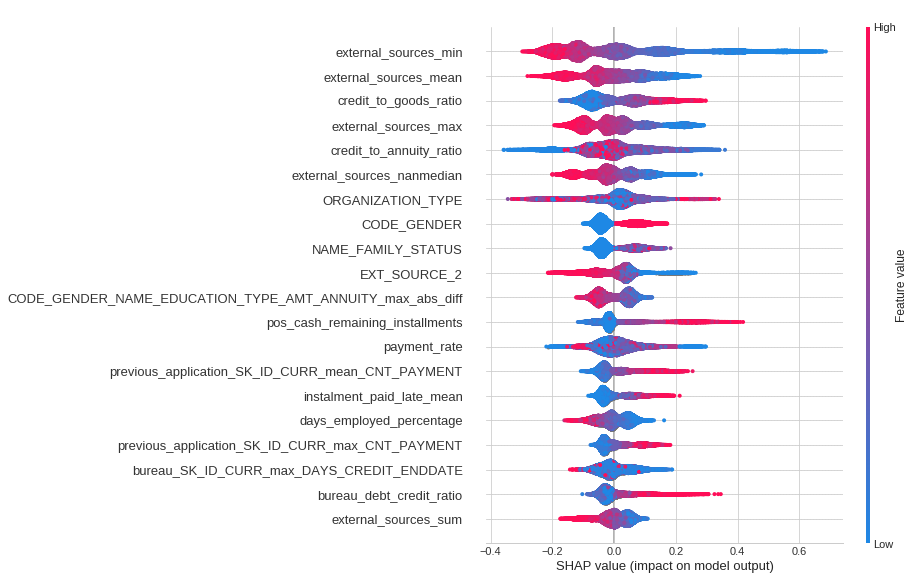

None

In [11]:
display(shap.summary_plot(shap_values, features_df, max_display=20))

In [12]:
@ipy.interact(
            cols = ipy.SelectMultiple(
                options=list(reversed(features_df.columns[inds])),
                rows=10,
                value=(list(reversed(features_df.columns[inds]))[0], ),
                description='Corr Columns',
                layout=ipy.Layout(width='90%')
            ),
            num_samples=ipy.IntSlider(
                value=250,
                min=100,
                max=1000,
                step = 50,
                continuous_update=False,
                description='Samples:',
                layout=ipy.Layout(width='90%', height='30px')
            )
)
def func(cols, num_samples):
    smp = sample(range(len(shap_values)), num_samples)
    for col in cols:
        display(shap.dependence_plot(col, shap_values[smp], features_df.loc[smp,:]))

interactive(children=(SelectMultiple(description='Corr Columns', index=(0,), layout=Layout(width='90%'), optio…

# Predictions

/mnt/ml-team/minerva/open-solutions/home-credit/milosz/envs/base_env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


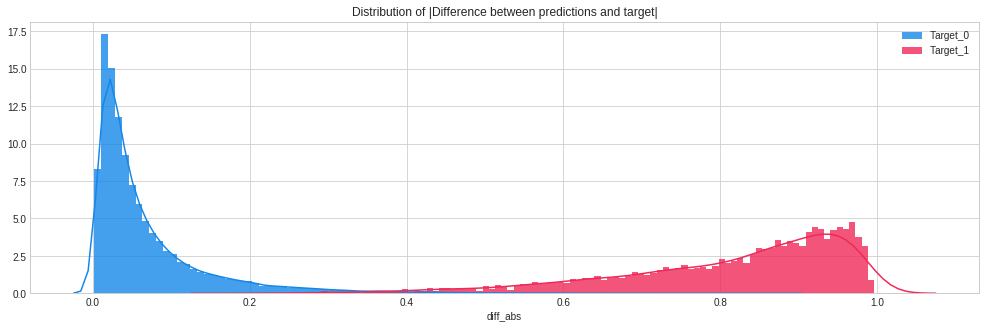

In [20]:
plt.figure(figsize=(17,5))

plt.title("Distribution of |Difference between predictions and target|")
sns.distplot(exploration_data[exploration_data['target']==0]['diff_abs'], 
             label='Target_0', 
             color='#1587E8',
             hist_kws={'alpha': 0.8},
             bins=100);
sns.distplot(exploration_data[exploration_data['target']==1]['diff_abs'], 
             label='Target_1',
             color='#F02958',
             hist_kws={'alpha': 0.8},
             bins=100);
plt.legend()
plt.show()

In [14]:
feature_analysis = features_df.copy()

In [39]:
feature_analysis['INDEX'] = index_list
feature_analysis['TARGET'] = exploration_data['target']
feature_analysis['DIFF'] = exploration_data['diff']
feature_analysis['DIFF_ABS'] = exploration_data['diff_abs']

/mnt/ml-team/minerva/open-solutions/home-credit/milosz/envs/base_env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


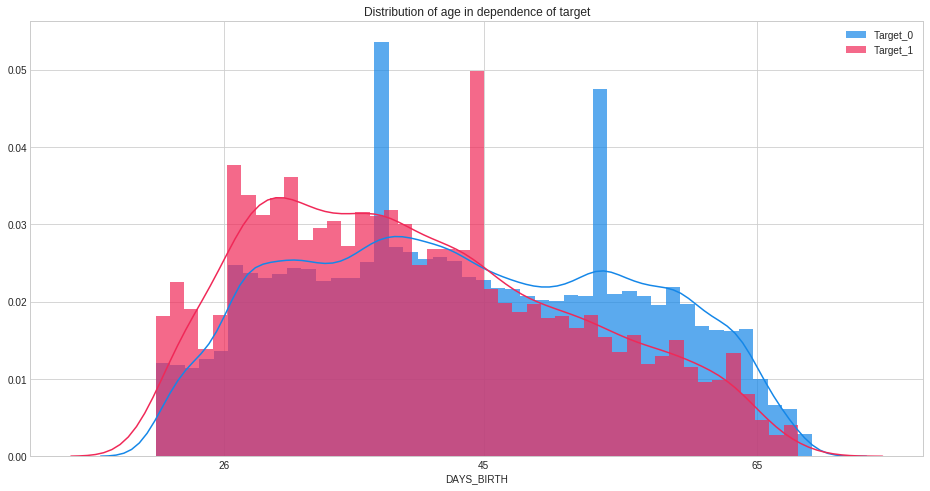

In [21]:
def get_age(fts, target=1):
    return -fts[fts['TARGET']==target]['DAYS_BIRTH']//365

plt.figure(figsize=(16,8))
plt.title("Distribution of age in dependence of target")
sns.distplot(get_age(feature_analysis, 0),
             label='Target_0', 
             color='#1587E8',
             hist_kws={'alpha': 0.7},
             bins=45);
sns.distplot(get_age(feature_analysis, 1),
             label='Target_1', 
             color='#F02958',
             hist_kws={'alpha': 0.7},
             bins=45);
plt.xticks([26, 45, 65], [26, 45, 65])
plt.legend()
plt.show()

In [23]:
@ipy.interact(
            cols = ipy.SelectMultiple(
                options=list(reversed(features_df.columns[inds])),
                rows=10,
                value=(list(reversed(features_df.columns[inds]))[0], ),
                description='Corr Columns',
                layout=ipy.Layout(width='90%')
            ),
            num_samples=ipy.IntSlider(
                value=250,
                min=100,
                max=1000,
                step = 50,
                continuous_update=False,
                description='Samples:',
                layout=ipy.Layout(width='90%', height='30px')
            )
)
def func(cols, num_samples):
    for col in cols:
        fig = plt.figure(figsize=(16, 8));
        target_1 = feature_analysis[feature_analysis['TARGET']==1]
        target_0 = feature_analysis[feature_analysis['TARGET']==0]
        smp_1 = sample(range(len(target_1)), min(num_samples, len(target_1)))
        smp_0 = sample(range(len(target_0)), min(num_samples, len(target_0)))
        df = pd.concat([target_1.iloc[smp_1,:], target_0.iloc[smp_0,:]], axis=0)
        display(sns.swarmplot(x='TARGET', y=col, data=df, palette=['#1587E8', '#F02958'],))
        plt.show()

interactive(children=(SelectMultiple(description='Corr Columns', index=(0,), layout=Layout(width='90%'), optio…

/mnt/ml-team/minerva/open-solutions/home-credit/milosz/envs/base_env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


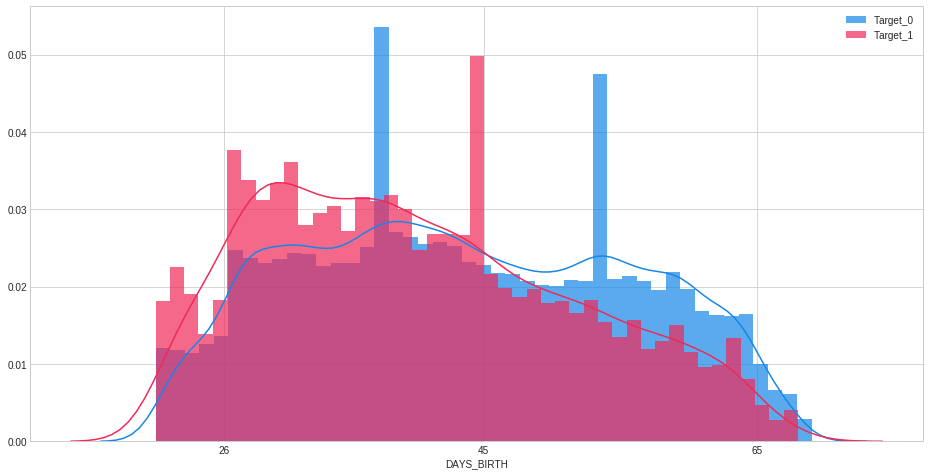

In [19]:
def get_age(fts, target=1):
    return -fts[fts['TARGET']==target]['DAYS_BIRTH']//365

plt.figure(figsize=(16, 8))
sns.distplot(get_age(feature_analysis, 0),             
             label='Target_0', 
             color='#1587E8',
             hist_kws={'alpha': 0.7},
             bins=45);
sns.distplot(get_age(feature_analysis, 1),             
             label='Target_1', 
             color='#F02958',
             hist_kws={'alpha': 0.7},
             bins=45);
plt.xticks([26, 45, 65], [26, 45, 65])
plt.legend()
plt.show()

In [46]:
@ipy.interact(
            diff=ipy.FloatRangeSlider(
                value=(0.9, 0.95),
                min=0.0,
                max=1.0,
                step=0.01,
                description='Features:',
                continuous_update=False,
                layout=ipy.Layout(width='90%', height='30px')
            ),
            num_rows=ipy.IntSlider(
                value=5,
                min=5,
                max=100,
                description='Num Rows:',
                continuous_update=False,
                layout=ipy.Layout(width='90%', height='30px')
            ))
def func(diff, num_rows):
    selected = feature_analysis[(diff[0] <= feature_analysis['DIFF_ABS']) & (feature_analysis['DIFF_ABS'] <= diff[1])]
    display(selected[['INDEX', "TARGET", "DIFF", 'DIFF_ABS']].head(min(num_rows, len(selected))))

interactive(children=(FloatRangeSlider(value=(0.9, 0.95), continuous_update=False, description='Features:', la…